In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

### Базовое знакомство с данными

In [2]:
df = pd.read_csv("data/train.csv")
df.head()

,Deal_id,Deal_date,First_deal_date,Secret_dwarf_info_1,Secret_dwarf_info_2,Secret_dwarf_info_3,First_default_date,Successful_deals_count,Region,Tavern,Hashed_deal_detail_1,Hashed_deal_detail_2,Hashed_deal_detail_3,Hashed_deal_detail_4,Hashed_deal_detail_5,Hashed_deal_detail_6,Age,Gender,Default
0,22487461,2015-11-05,2015-08-29,NaN,NaN,NaN,NaN,0.0,Tavern_district_3,7,2.5,-3,8,2.5,-3,5,36.0,Male,0
1,62494261,2016-08-26,2015-12-21,3.5,-2.0,5.0,2016-07-30,2.0,Tavern_district_4,7,2.5,-3,14,3.5,-3,5,29.0,Female,1
2,34822849,2016-02-18,2015-11-11,NaN,NaN,NaN,NaN,0.0,Tavern_district_6,7,2.5,-3,8,2.5,-3,5,56.0,Female,0
3,46893387,2016-04-30,2016-03-22,NaN,NaN,NaN,NaN,0.0,Tavern_district_2,13,2.5,-2,5,2.5,-3,5,27.0,Female,0
4,67128275,2016-09-19,2016-07-21,NaN,NaN,NaN,NaN,0.0,Tavern_district_4,39,2.5,-3,7,2.5,-3,5,37.0,Female,0


Взглянем на таргет. Оценим дисбаланс классов.

In [3]:
df['Default'].value_counts()

0    2817
1     351
Name: Default, dtype: int64

Дисбаланс классов на лицо. Следовательно использовать accuracy в качестве метрики было бы опрометчиво. Соответственно для оценки качества выберем метрику PR-AUC.

### Работа с пропусками

Оценим кол-во пропусков в данных.

In [4]:
df.shape

(3168, 19)

In [5]:
df.isna().sum()

Deal_id                      0
Deal_date                    0
First_deal_date              0
Secret_dwarf_info_1       2633
Secret_dwarf_info_2       2633
Secret_dwarf_info_3       2633
First_default_date        2633
Successful_deals_count      14
Region                       7
Tavern                       0
Hashed_deal_detail_1         0
Hashed_deal_detail_2         0
Hashed_deal_detail_3         0
Hashed_deal_detail_4         0
Hashed_deal_detail_5         0
Hashed_deal_detail_6         0
Age                          0
Gender                       0
Default                      0
dtype: int64

Посмотрим на пропуски информации о гномах.

In [6]:
df[['Secret_dwarf_info_1','Secret_dwarf_info_2', 'Secret_dwarf_info_3']].nunique()

Secret_dwarf_info_1    8
Secret_dwarf_info_2    6
Secret_dwarf_info_3    4
dtype: int64

Исходя из столь малого кол-ва уникальных значений, несмотря на числовые значения можно сделать предположение что это категориальные признаки и заполнить пропуски наиболее часто встречающимся значением. И далее попробовать работать с данными фичами как с категориальными, возможно это положительно скажется на качестве.

In [7]:
df['Secret_dwarf_info_1'].value_counts()

3.5    384
4.5     89
5.5     39
6.5     11
2.5      4
7.5      4
8.5      3
9.5      1
Name: Secret_dwarf_info_1, dtype: int64

In [8]:
popular_info_1 = df['Secret_dwarf_info_1'].value_counts().index[0]
df['Secret_dwarf_info_1'] = df['Secret_dwarf_info_1'].fillna(popular_info_1)

Для фичи 'Secret_dwarf_info_2' примерно равное кол-во двух наиболее часто встречающихся значений. Попробуем заполнить пропуски данной колонки из сгенерированных случайным образом последовательности из этих двух значений.

In [9]:
df['Secret_dwarf_info_2'].value_counts()

-2.0    243
-3.0    232
-1.0     51
 0.0      7
 2.0      1
 1.0      1
Name: Secret_dwarf_info_2, dtype: int64

In [10]:
info_2 = pd.Series(np.random.randint(-3, -1, df.shape[0]))
df['Secret_dwarf_info_2'] = df['Secret_dwarf_info_2'].fillna(info_2)

In [11]:
df['Secret_dwarf_info_3'].value_counts()

5.0    405
6.0    118
7.0     11
8.0      1
Name: Secret_dwarf_info_3, dtype: int64

df.dtypesДля фичи 'Secret_dwarf_info_3' поступим аналогично 'Secret_dwarf_info_1'.

In [12]:
popular_info_3 = df['Secret_dwarf_info_3'].value_counts().index[0]
df['Secret_dwarf_info_3'] = df['Secret_dwarf_info_3'].fillna(popular_info_3)

Прежде чем придумывать как осмысленно заполнить пропуски колонки 'First_default_date'. Стоит понять а должны ли быть в принципе какие либо значения в данной колонке. Каждый заказ относится к какому то конкретному гному, если в колонке 'First_default_date' стоит значение, это значит что гном, которому принадлежал данный заказ - дефолтил когда либо в принципе, соответственно заполнив пропуски данной колонки(предидущим, последующим или самым часто встречающимся значением) - мы заведомо того не зная, внесем в данные информацию в которой нет уверенности, также интуитивно кажется, что таргет дефолтнет покупка или нет зависит скорее от параметров гнома и покупки, нежели от даты первого дефолта, несмотря на то что данная фича говорит нам о важном факторе дефолтил ли когда либо данный гном или нет. Тогда стоит попробовать идентифицировать гномов через поиск похожих и присваивая дату первого дефолта похожим объектам.

In [13]:
df['First_default_date'] = pd.to_datetime(df['First_default_date'])

Кажется крайне строгим и жестким присваивать дату(факт того что гном дефолтил когда-либо) по похожести исходя из условия что гном принадлежит сразу нескольким категориям, в том числе по возрасту. Так например по данным ниже мы можем увидеть что в Tavern_district_0, таверне 7, гендера Female, гномов в возрасте 21 год - 6 гномов, об этом говорит разная дата первого заказа.

In [14]:
df.groupby(['Region', 
            'Tavern',
            'Gender', 
            'Age'])['First_deal_date'].nunique()

Region             Tavern  Gender  Age 
Tavern_district_0  7       Female  20.0    2
                                   21.0    6
                                   22.0    4
                                   23.0    6
                                   24.0    3
                                          ..
Tavern_district_7  27      Female  40.0    1
                                   45.0    1
                                   54.0    1
                           Male    41.0    1
                                   42.0    1
Name: First_deal_date, Length: 1331, dtype: int64

В то же время группируя по тем же категориям мы видим что дефолтящих гномов(по факту наличия даты первого дефолта) меньше чем в принципе гномов принадлежащих конкретному набору категорий. Таким образом если мы будем присваивать всем гномам соответсвующим конкретным наборам категорий дату первого дефолта(маркер того дефолтили они или нет) - мы можем сильно испортить данные.

In [15]:
df.groupby(['Region', 
            'Tavern',
            'Gender', 
            'Age'])['First_default_date'].nunique()

Region             Tavern  Gender  Age 
Tavern_district_0  7       Female  20.0    1
                                   21.0    2
                                   22.0    1
                                   23.0    3
                                   24.0    2
                                          ..
Tavern_district_7  27      Female  40.0    0
                                   45.0    0
                                   54.0    0
                           Male    41.0    0
                                   42.0    0
Name: First_default_date, Length: 1331, dtype: int64

Но мы можем заполнить даты дефолта только тем гномам кто точно когда-то дефолтил - проведем поиск похожих среди тех у кого заказ дефолтил.

In [16]:
grouped_means = df[df['Default']==1].groupby(['Region', 
                              'Tavern',
                              'Gender', 
                              'Age'])['First_default_date'].transform('max')

In [17]:
grouped_means

1      2016-07-30
5             NaT
10            NaT
16     2015-08-30
18            NaT
          ...    
3140   2016-01-15
3145   2015-11-13
3154          NaT
3158   2016-07-30
3165          NaT
Name: First_default_date, Length: 351, dtype: datetime64[ns]

In [18]:
df.loc[df['Default']==1,'First_default_date'] = df[df['Default']==1]['First_default_date'].fillna(grouped_means)

Также выставим в данной колонке 1 - факт того что данный гном когда-либо дефолтил если таргет равен 1. Остальные NaN примем за то что данный гном никогда не дефолтил.

In [19]:
df.loc[df['Default']!=0,'First_default_date'] = 1

In [20]:
df.isna().sum()

Deal_id                      0
Deal_date                    0
First_deal_date              0
Secret_dwarf_info_1          0
Secret_dwarf_info_2          0
Secret_dwarf_info_3          0
First_default_date        2398
Successful_deals_count      14
Region                       7
Tavern                       0
Hashed_deal_detail_1         0
Hashed_deal_detail_2         0
Hashed_deal_detail_3         0
Hashed_deal_detail_4         0
Hashed_deal_detail_5         0
Hashed_deal_detail_6         0
Age                          0
Gender                       0
Default                      0
dtype: int64

Можно заметить что все равно осталось достаточно много пропусков данной колонки. Таким образом не получится использовать ее для построения модели, более того мы не будем знать заранее таргетную переменную на входящих объектов. И заполнять пропуски смотря на таргет не получится.

Удалим объекты с пропущеными значениями в колонке 'Successful_deals_count' и 'Region' так как их крайне мало.

In [21]:
df = df.dropna(subset=['Successful_deals_count', 'Region'])

### EDA

In [22]:
import matplotlib as mlp

mlp.rcParams['lines.linewidth'] = 5
mlp.rcParams['xtick.major.size'] = 20
mlp.rcParams['xtick.major.width'] = 5
mlp.rcParams['xtick.labelsize'] = 20
mlp.rcParams['xtick.color'] = '#FF5533'

mlp.rcParams['ytick.major.size'] = 20
mlp.rcParams['ytick.major.width'] = 5
mlp.rcParams['ytick.labelsize'] = 20
mlp.rcParams['ytick.color'] = '#FF5533'

mlp.rcParams['axes.labelsize'] = 20
mlp.rcParams['axes.titlesize'] = 20
mlp.rcParams['axes.titlecolor'] = '#00B050'
mlp.rcParams['axes.labelcolor'] = '#00B050'

Так как уникальных значений в большинстве не так много, попробуем принять их как категориальные фичи и построить модель, возможно это даст хороший резульат. Но сперва убедимся что фичи имеют разное распределение в зависимости от таргетной переменной и вносить весомый вклад в построение модели.

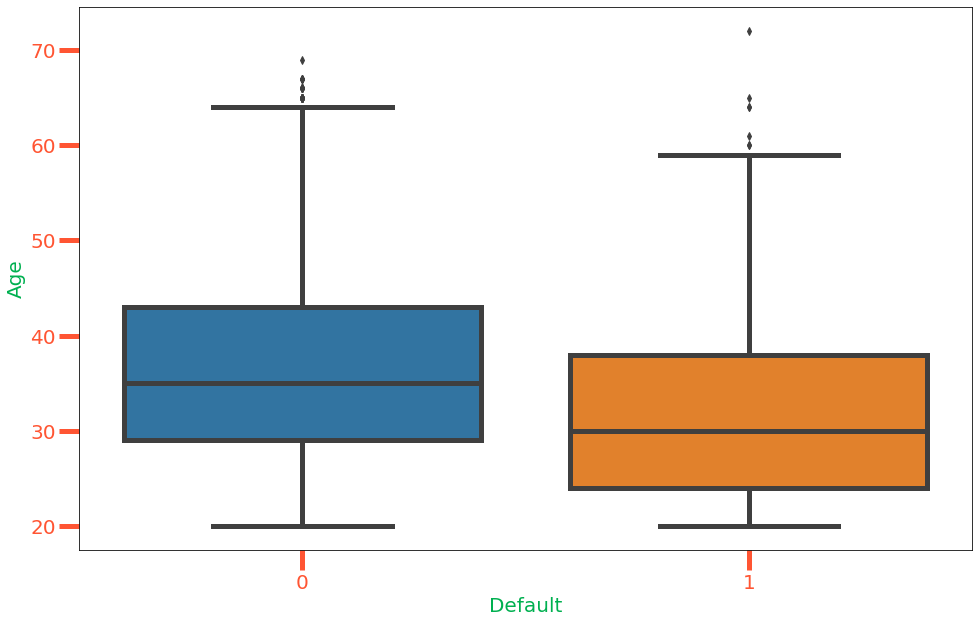

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns


fig = plt.figure()
fig.set_size_inches(16, 10)
    
sns.boxplot(y=df['Age'], x=df['Default'].astype('category'), data=df)
    
plt.show()

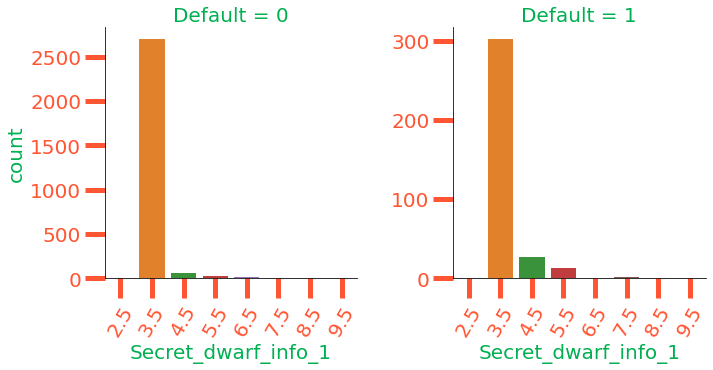

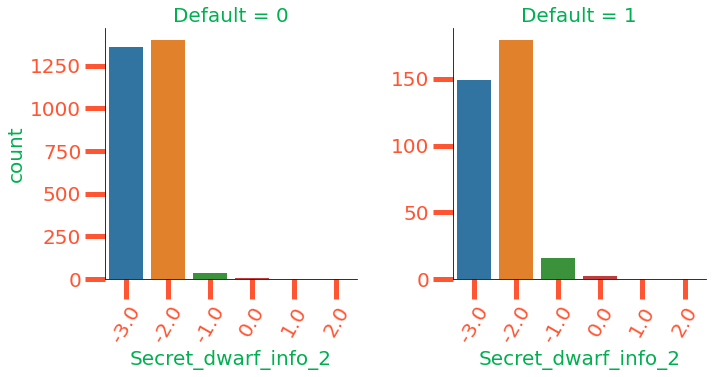

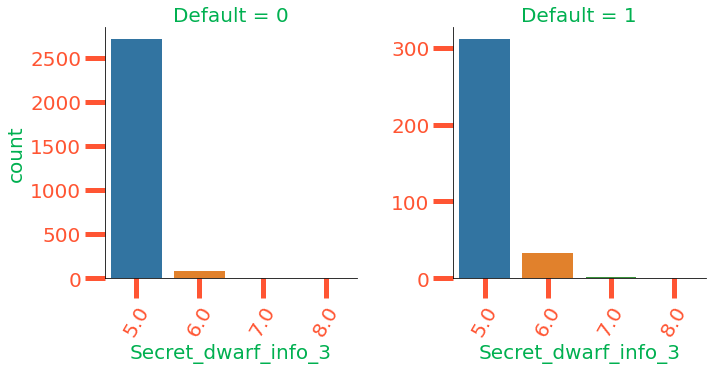

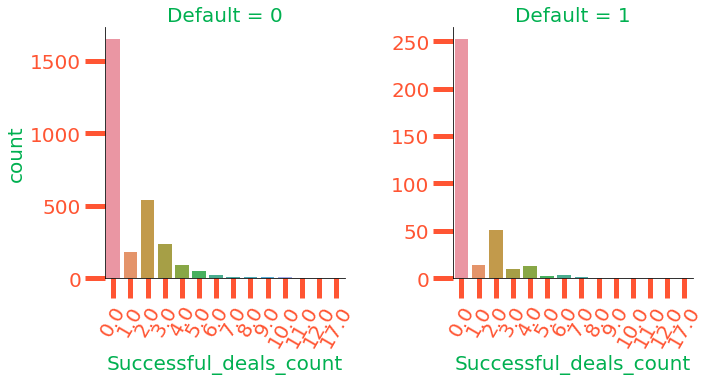

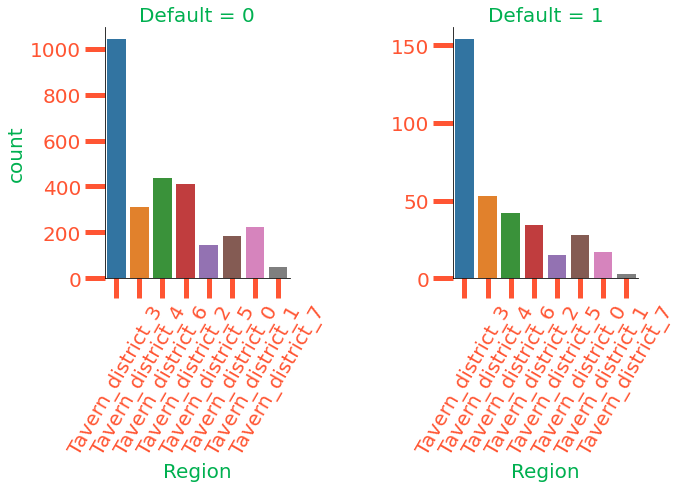

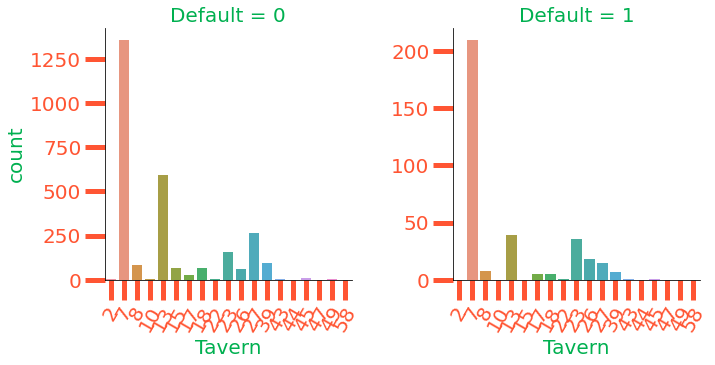

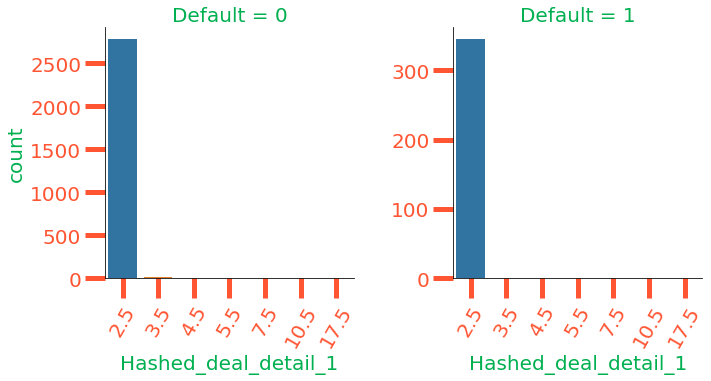

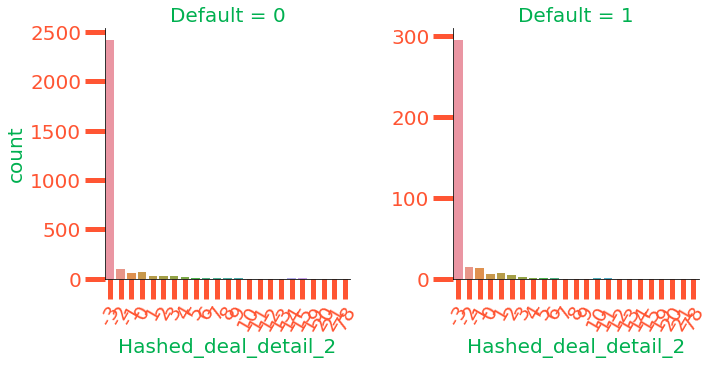

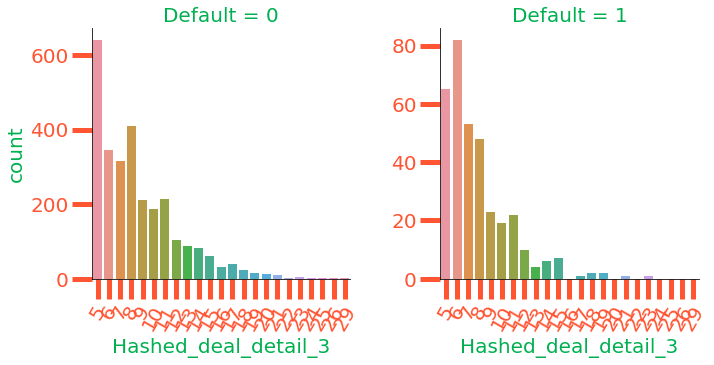

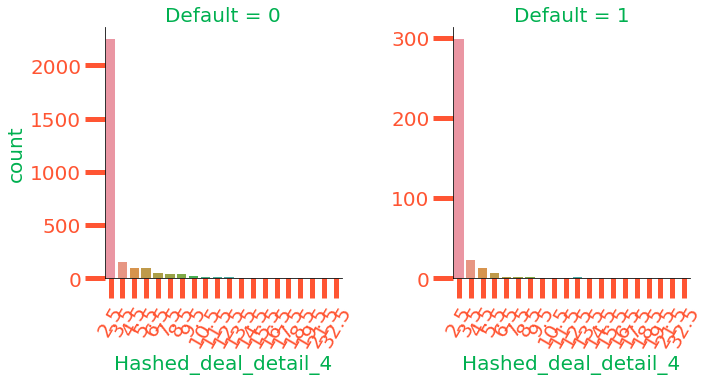

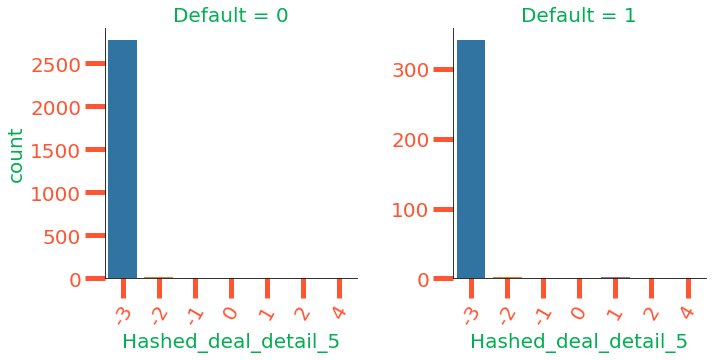

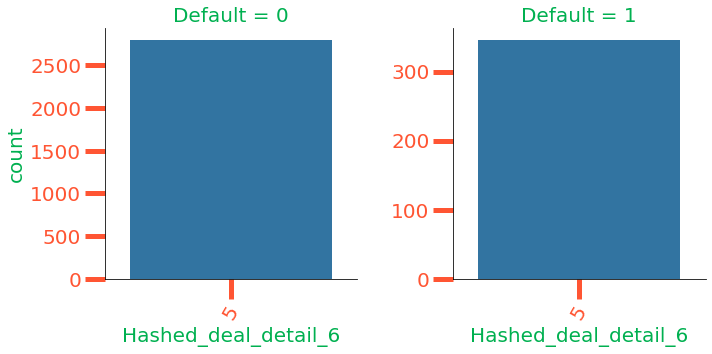

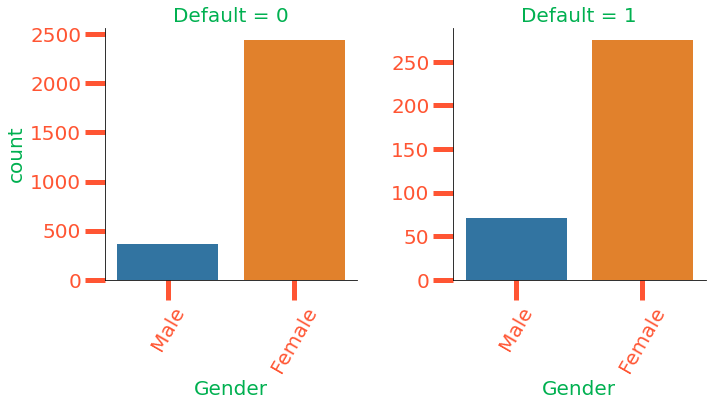

In [24]:
categorical_columns = ['Secret_dwarf_info_1', 'Secret_dwarf_info_2', 'Secret_dwarf_info_3',
       'Successful_deals_count', 'Region', 'Tavern', 'Hashed_deal_detail_1', 
       'Hashed_deal_detail_2', 'Hashed_deal_detail_3', 'Hashed_deal_detail_4', 
       'Hashed_deal_detail_5', 'Hashed_deal_detail_6', 'Gender']

### Гистограммы распределений в разных классах

for col in categorical_columns:
    g = sns.catplot(x=col, kind='count', col='Default', data=df, sharey=False)
    g.set_xticklabels(rotation=60)

Из гистограм распределений видно что признак 'Hashed_deal_detail_6' константный, избавимся от него. Также можно заметить что распределения признаков 'Hashed_deal_detail_1' и 'Hashed_deal_detail_5' крайне похожи. Проверим их на квазиконстрантность.

In [25]:
numeric_columns = ['Hashed_deal_detail_1', 'Hashed_deal_detail_5', 'Age']

In [26]:
### Посмотрим на квазиконстантые признаки

from sklearn.feature_selection import VarianceThreshold


cutter = VarianceThreshold(threshold=0.2)
cutter.fit(df[numeric_columns])

cutter.get_feature_names_out()

array(['Age'], dtype=object)

In [27]:
df = df.drop(['Deal_id', 'Deal_date', 'First_deal_date', 'First_default_date',
         'Hashed_deal_detail_1', 'Hashed_deal_detail_5', 'Hashed_deal_detail_6'], axis = 1)

Закодируем категориальные фичи с помощью one-hot, так как категорий не очень много то закодируем целиком, без использования счетчиков.

In [28]:
categorical_columns = ['Secret_dwarf_info_1', 'Secret_dwarf_info_2', 'Secret_dwarf_info_3',
       'Successful_deals_count', 'Region', 'Tavern', 'Hashed_deal_detail_2', 
       'Hashed_deal_detail_3', 'Hashed_deal_detail_4', 'Gender']

for col in categorical_columns:
    one_hot = pd.get_dummies(df[col], prefix=col, drop_first=True)
    df = pd.concat((df.drop(col, axis=1), one_hot), axis=1)

### Построим базовую модель в качестве бейзлайна.

Используем стратифицированное разделение в силу дизбаланса классов.

Делается для того чтобы в тестовую выборку попало достаточное кол-во объектов класса 1 чтобы была возможность оценить качество модели. Также если на трейне у нас случайно не окажется объектов 1 класса, мы не сможем определить их на тесте. От этого будет страдать обобщающая способность модели. Стратификация позволяет сделать распределение таргетов в трейне и тесте таким, каким оно примерно является в общей совокупности.

Убедимся, что действительно и в трейне, и в тесте схожая доля каждой тары.

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


df_train, df_test = train_test_split(
    df,
    test_size=0.1,
    stratify=df['Default']
)

pipeline_baseline = Pipeline([('scaler', StandardScaler()),
                             ('LR', LogisticRegression(penalty='none'))])

In [30]:
train_shares = df_train['Default'].value_counts() / df_train.shape[0]
test_shares = df_test['Default'].value_counts() / df_test.shape[0]

to_compare = pd.concat((train_shares, test_shares), axis=1)
to_compare.columns = ['Доля в трейне', 'Доля в тесте']
to_compare['Абсолютная разница'] = (to_compare['Доля в трейне'] - \
                                    to_compare['Доля в тесте']).abs()

to_compare

,Доля в трейне,Доля в тесте,Абсолютная разница
0,0.890184,0.888889,0.001295
1,0.109816,0.111111,0.001295


In [31]:
pipeline_baseline.fit(
    df_train.drop('Default', axis = 1),
    df_train['Default']
)

train_preds = pipeline_baseline.predict(df_train.drop('Default', axis = 1)) 
train_accuracy = np.mean(train_preds == df_train['Default'].values)

test_preds = pipeline_baseline.predict(df_test.drop('Default', axis = 1)) 
test_accuracy = np.mean(test_preds == df_test['Default'].values)

print(f"Accuracy на тренировочной выборке составило {np.round(train_accuracy, decimals=3)}")
print(f"Accuracy на тестовой выборке составило {np.round(test_accuracy, decimals=3)}")

Accuracy на тренировочной выборке составило 0.892
Accuracy на тестовой выборке составило 0.892


Но оценивать модель по Accuracy при дисбалансе классов некорректно, дав константное предстказание мы получим ту же Accuracy. Воспользуемся метрикой PR-AUC для оценки обобщающей способности.

In [32]:
from sklearn.metrics import precision_score


precision_score(df_test['Default'], pipeline_baseline.predict(df_test.drop('Default', axis = 1)))

0.6666666666666666

Достаточно неплохой precision на тестовых данных. Но PR-AUC оценит модель более обобщающе.

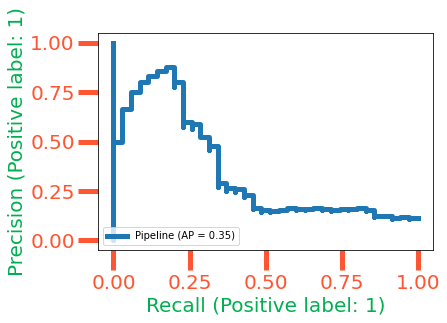

In [33]:
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_estimator(pipeline_baseline, df_test.drop('Default', axis = 1), df_test['Default'])

Судя по PR кривой наша модель плохо оценивает вероятность для объектов положительного класса. Так как логистическая регрессия использует в качестве функции потель логарифмическую функцию, которая корректно оценивает вероятности, то скорее всего наши данные имеют нелинейную зависимость. Попробуем построить модель используя метод ближайших соседей.

In [34]:
from sklearn.neighbors import KNeighborsClassifier


pipeline_KNN = Pipeline([('scaler', StandardScaler()),
                         ('default_KNN', KNeighborsClassifier())])

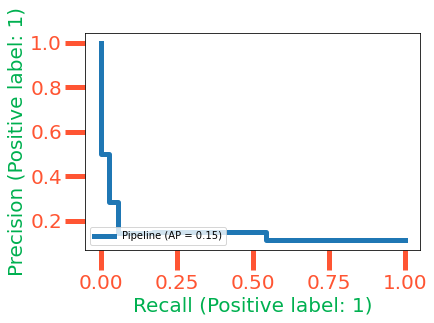

In [35]:
pipeline_KNN.fit(
    df_train.drop('Default', axis = 1),
    df_train['Default']
)

PrecisionRecallDisplay.from_estimator(pipeline_KNN, df_test.drop('Default', axis = 1), df_test['Default'])

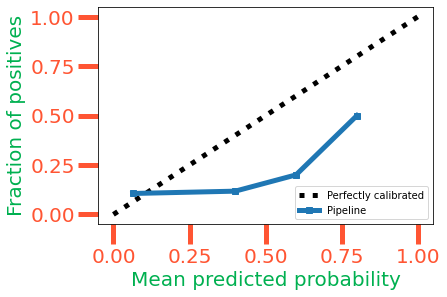

In [36]:
from sklearn.calibration import CalibrationDisplay


CalibrationDisplay.from_estimator(pipeline_KNN, df_test.drop('Default', axis = 1), df_test['Default'])

Очень слабо. Можно попробовать откаллибровать вероятности, но продуктивнее будет двигаться дальше. Построим модель градиентного бустинга.

In [37]:
from sklearn.ensemble import GradientBoostingClassifier

pipeline_GB = Pipeline([('scaler', StandardScaler()),
                         ('default_GB', GradientBoostingClassifier())])

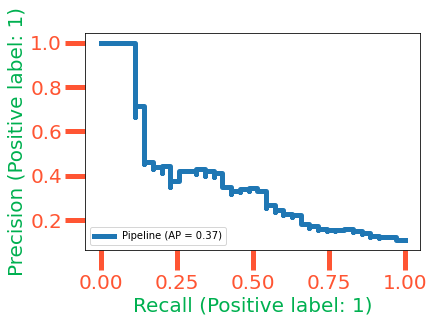

In [38]:
pipeline_GB.fit(
    df_train.drop('Default', axis = 1),
    df_train['Default']
)

PrecisionRecallDisplay.from_estimator(pipeline_GB, df_test.drop('Default', axis = 1), df_test['Default'])

Хуже чем логистическая регрессия, попробуем найти параметры которые дадут лучшую долю правильно размеченых объектов положительного класса.

In [39]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "default_GB__n_estimators": [10, 50, 100, 500],
    "default_GB__learning_rate": [0.1, 0.01, 0.001],
    "default_GB__max_depth": [2, 3, 5, 10]
}

search = GridSearchCV(pipeline_GB, 
                      param_grid, 
                      cv=5,
                      scoring='precision')

search.fit(df_train.drop('Default', axis = 1), df_train['Default'])

print(f"Best parameter (CV score={search.best_score_:.5f}):")
print(search.best_params_)

print(f"Качество лучшей модели на финальном тесте: {search.score(df_test.drop('Default', axis = 1), df_test['Default'])}")

Best parameter (CV score=0.45333):
{'default_GB__learning_rate': 0.1, 'default_GB__max_depth': 2, 'default_GB__n_estimators': 100}
Качество лучшей модели на финальном тесте: 1.0


Ужасное качество на финальном тесте. Вероятнее всего модель переобучается, что свойственно градиентному бустингу. В таком случае вернемся к линейным моделям и попробуем подобрать параметры модели, которые дадут наибольший precision.

In [40]:
param_grid_LR = {
    'LR__penalty': ['l1', 'l2', 'elasticnet']
}

search_LR = GridSearchCV(pipeline_baseline, 
                      param_grid_LR, 
                      cv=5,
                      scoring='precision')

search_LR.fit(df_train.drop('Default', axis = 1), df_train['Default'])

print(f"Best parameter (CV score={search_LR.best_score_:.5f}):")
print(search_LR.best_params_)

print(f"Качество лучшей модели на финальном тесте: {search_LR.score(df_test.drop('Default', axis = 1), df_test['Default'])}")

Best parameter (CV score=0.32879):
{'LR__penalty': 'l2'}
Качество лучшей модели на финальном тесте: 0.6666666666666666


Без изменений. Дефолтная L2 регуляризация дает наибольший precision на финальном тесте. Поробуем построить SVM и также оценить precision.

In [41]:
from sklearn.svm import LinearSVC

pipe_svm = Pipeline([("scaler_svm", StandardScaler()),
                     ("SVM", LinearSVC())])


pipe_svm.fit(df_train.drop('Default', axis = 1), df_train['Default'])

precision_score(df_test['Default'].astype(int), pipe_svm.predict(df_test.drop('Default', axis = 1)))

0.3333333333333333

Подводя итог выше проделанной работе можно прийти к следующим выводам, если не получается кардинально улучшить метрику PR-AUC и улучшить обобщающую способность модели, то оставим базовую модель.

Оценим ROC-AUC модели.

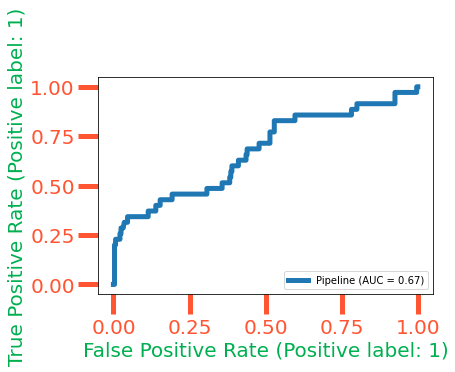

In [42]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(pipeline_baseline, df_test.drop('Default', axis = 1), df_test['Default'])

Достаточно неплохо, можно сделать вывод что несмотря на низкий precision, при высоком recall мы будем корректно определять положительный класс, но большое кол-во объектов класса 0 также будут определены как положительный. Да, мы сможем избежать потерь корректно определяя дефолтящие заказы, но в то же время будем терять прибыль ложно обозначая дефолтящими заказы, которые таковыми не являются.

### Кастомный трансформер

Проверим на тестовых данных. Для этого напишем кастомный трансформер предобработки данных для переиспользования. Предварительно обучив модель на всей выборке, так как данных мало, это может дать прирост в качестве.

In [43]:
pipeline_baseline.fit(
    df.drop('Default', axis = 1),
    df['Default'].astype(int)
)

Pipeline(steps=[('scaler', StandardScaler()),
                ('LR', LogisticRegression(penalty='none'))])

In [44]:
from sklearn.base import BaseEstimator, TransformerMixin
import itertools

class CustomFunctionTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self,
                 categorical_columns=[],
                 target_name='Default'):
        
        self.categorical_columns = categorical_columns
        self.target_name = target_name
        
                
    def fit(self,
            X,
            y):
        
        X_fit = X.copy()
        y_fit = y.copy()
        
        self.numeric_columns = ['Age']
        
        X_with_target = pd.concat((X_fit, y_fit), axis=1)
        
        popular_info_1 = X_with_target['Secret_dwarf_info_1'].value_counts().index[0]
        X_with_target['Secret_dwarf_info_1'] = X_with_target['Secret_dwarf_info_1'].fillna(popular_info_1)
        
        self.info_2 = pd.Series(np.random.randint(-3, -1, X_with_target.shape[0]))
        X_with_target['Secret_dwarf_info_2'] = X_with_target['Secret_dwarf_info_2'].fillna(self.info_2)
        
        popular_info_3 = X_with_target['Secret_dwarf_info_3'].value_counts().index[0]
        X_with_target['Secret_dwarf_info_3'] = X_with_target['Secret_dwarf_info_3'].fillna(popular_info_3)
        
        X_with_target = X_with_target.dropna(subset=['Successful_deals_count', 'Region'])
        
        ### Сгенерим колонки к которым применим One-Hot-Encoding
        self.cols_for_ohe = ['Secret_dwarf_info_1', 'Secret_dwarf_info_2', 'Secret_dwarf_info_3',
       'Successful_deals_count', 'Region', 'Tavern', 'Hashed_deal_detail_2', 
       'Hashed_deal_detail_3', 'Hashed_deal_detail_4', 'Gender']
        
        ### Запомним все ohe колонки и их названия!
        self.ohe_names = {col : sorted([f"{col}_{value}" for value in X_with_target[col].unique()])
                          for col in self.cols_for_ohe}
        
        return self
    
    def transform(self,
                  X,
                  y=None):
        
        X_ = X.copy()
        

        X_ = X_[self.cols_for_ohe].astype('category')
        data_part = pd.get_dummies(X_[self.cols_for_ohe],
                                   prefix=self.cols_for_ohe)
        
        data_part_cols = data_part.columns
        
        X_ = X_.drop(self.cols_for_ohe, axis=1)
        
        X_ = pd.concat((X_, data_part), axis=1)
            
            
        all_ohe = list(itertools.chain(*list(transformer.ohe_names.values())))
        
        missing_columns = [x 
                           for x in all_ohe
                           if x not in X_.columns
                           and
                           x not in self.numeric_columns]

        extra_columns = [x
                         for x in data_part_cols
                         if x not in all_ohe]
        
        ### Новые категории необходимо убрать
        X_ = X_.drop(extra_columns, axis=1)
    
        ### Отсутствующие категории (бинарные колонки)
        ### необходимо добавить: заполним их просто нулями
        
        if len(missing_columns) != 0:

            zeros = np.zeros((X_.shape[0], len(missing_columns)))
            zeros = pd.DataFrame(zeros,
                                 columns=missing_columns,
                                 index=X_.index)

            X_ = pd.concat((X_, zeros), axis=1)
        
        X_ = X_.drop(['Gender_Female'], axis=1)
        
        return X_[sorted(X_.columns)]

In [45]:
df = pd.read_csv("/kaggle/input/dwarf-data/train.csv")
df.head()

,Deal_id,Deal_date,First_deal_date,Secret_dwarf_info_1,Secret_dwarf_info_2,Secret_dwarf_info_3,First_default_date,Successful_deals_count,Region,Tavern,Hashed_deal_detail_1,Hashed_deal_detail_2,Hashed_deal_detail_3,Hashed_deal_detail_4,Hashed_deal_detail_5,Hashed_deal_detail_6,Age,Gender,Default
0,22487461,2015-11-05,2015-08-29,NaN,NaN,NaN,NaN,0.0,Tavern_district_3,7,2.5,-3,8,2.5,-3,5,36.0,Male,0
1,62494261,2016-08-26,2015-12-21,3.5,-2.0,5.0,2016-07-30,2.0,Tavern_district_4,7,2.5,-3,14,3.5,-3,5,29.0,Female,1
2,34822849,2016-02-18,2015-11-11,NaN,NaN,NaN,NaN,0.0,Tavern_district_6,7,2.5,-3,8,2.5,-3,5,56.0,Female,0
3,46893387,2016-04-30,2016-03-22,NaN,NaN,NaN,NaN,0.0,Tavern_district_2,13,2.5,-2,5,2.5,-3,5,27.0,Female,0
4,67128275,2016-09-19,2016-07-21,NaN,NaN,NaN,NaN,0.0,Tavern_district_4,39,2.5,-3,7,2.5,-3,5,37.0,Female,0


Проверим корректно ли работает трансформер.

In [46]:
transformer = CustomFunctionTransformer(categorical_columns=categorical_columns,
                                       target_name='Default')

transformer.fit(df.drop('Default', axis = 1), df['Default'])

CustomFunctionTransformer(categorical_columns=['Secret_dwarf_info_1',
                                               'Secret_dwarf_info_2',
                                               'Secret_dwarf_info_3',
                                               'Successful_deals_count',
                                               'Region', 'Tavern',
                                               'Hashed_deal_detail_2',
                                               'Hashed_deal_detail_3',
                                               'Hashed_deal_detail_4',
                                               'Gender'])

In [47]:
check_train = transformer.transform(df)

In [48]:
check_train.head()

,Gender_Male,Hashed_deal_detail_2_-1,Hashed_deal_detail_2_-2,Hashed_deal_detail_2_-3,Hashed_deal_detail_2_0,Hashed_deal_detail_2_1,Hashed_deal_detail_2_10,Hashed_deal_detail_2_11,Hashed_deal_detail_2_12,Hashed_deal_detail_2_13,...,Tavern_27,Tavern_39,Tavern_43,Tavern_44,Tavern_45,Tavern_47,Tavern_49,Tavern_58,Tavern_7,Tavern_8
0,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [73]:
pipe = Pipeline([('custom_transformer',
                  CustomFunctionTransformer(categorical_columns=categorical_columns,
                                            target_name='Default')),
                 ('scaler', StandardScaler()),
                 ('default_GB', GradientBoostingClassifier(n_estimators=5, learning_rate=0.5, max_depth=2))])

pipe.fit(df.drop('Default', axis = 1), df['Default'])

Pipeline(steps=[('custom_transformer',
                 CustomFunctionTransformer(categorical_columns=['Secret_dwarf_info_1',
                                                                'Secret_dwarf_info_2',
                                                                'Secret_dwarf_info_3',
                                                                'Successful_deals_count',
                                                                'Region',
                                                                'Tavern',
                                                                'Hashed_deal_detail_2',
                                                                'Hashed_deal_detail_3',
                                                                'Hashed_deal_detail_4',
                                                                'Gender'])),
                ('scaler', StandardScaler()),
                ('default_GB',
                 GradientBoostingClassifier(

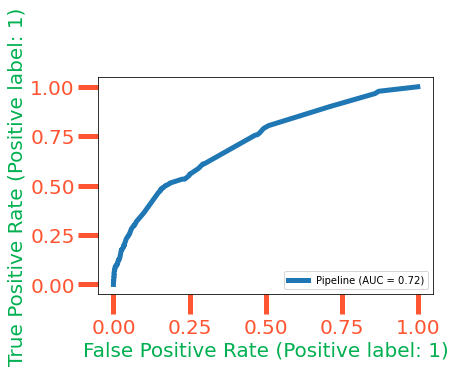

In [74]:
RocCurveDisplay.from_estimator(pipe, df.drop('Default', axis = 1), df['Default'])

In [61]:
df_test = pd.read_csv("data/test.csv")
df_test.head()

,Deal_id,Deal_date,First_deal_date,Secret_dwarf_info_1,Secret_dwarf_info_2,Secret_dwarf_info_3,First_default_date,Successful_deals_count,Region,Tavern,Hashed_deal_detail_1,Hashed_deal_detail_2,Hashed_deal_detail_3,Hashed_deal_detail_4,Hashed_deal_detail_5,Hashed_deal_detail_6,Age,Gender
0,72875713,2016-10-14,2015-09-20,NaN,NaN,NaN,NaN,0.0,Tavern_district_2,7,2.5,-3,18,2.5,-3,5,40.0,Female
1,75825544,2016-10-23,2015-06-16,NaN,NaN,NaN,NaN,6.0,Tavern_district_3,18,2.5,-2,15,3.5,-3,5,66.0,Female
2,81809181,2016-11-17,2016-09-11,NaN,NaN,NaN,NaN,0.0,Tavern_district_3,7,2.5,-3,7,2.5,-3,5,36.0,Female
3,87083256,2016-12-26,2016-06-25,NaN,NaN,NaN,NaN,0.0,Tavern_district_4,7,2.5,-2,6,2.5,2,5,32.0,Female
4,84651519,2016-12-07,2016-10-15,NaN,NaN,NaN,NaN,0.0,Tavern_district_3,7,2.5,-3,6,2.5,-3,5,37.0,Female


In [75]:
test_preds = pd.DataFrame({'Prediction': pipe.predict_proba(df_test)[:, 1]})
test_preds_df = pd.DataFrame(df_test['Deal_id'])
test_preds_df = pd.concat([test_preds_df, test_preds], axis=1)

In [76]:
test_preds_df.to_csv('data/output.csv')

### В каком направлении улучшать?

Можно попробовать выделить новые признаки, путем возведения в степень некоторых фичей и построить полиномиальную модель. Также можно снизить размерность пространства признаков методом главных компонент(PCA) и кластеризовать объекты. Расстояние до определенного кластера можно использовать в качестве нового признака. Спарсить годы месяцы и дни из дат также может быть полезным.